# Solución etapa 4 - Training - Predict v1

In [48]:
# Utilidades para print
from utils.print_utils import tabl, headr, titl
from utils.explore_utils import explr

In [49]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect

from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster


In [50]:
version_to_load='v1'

In [51]:
# Cargar el dataset
csv_path = f'../data/preprocessed/preprocessed_data_{version_to_load}.csv'
print('... Loading:', csv_path,'...')
final_data = pd.read_csv(csv_path)

tabl(final_data)

... Loading: ../data/preprocessed/preprocessed_data_v1.csv ...
      ID_Equipo  Fecha         Temperatura_C    Vibracion_mm_s    Horas_Operativas    Fallo  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  -----------  ----------  ---------------  ----------------  ------------------  -------  -------------  ------------  --------  -------------  -----------------------------
 0            1  2021-01-01          34.7499          2.13681                  614        0  Bomba          Fabricante_C  Modelo_6            173                            913
 1            1  2021-01-03          56.2006          1.52939                  658        0  Bomba          Fabricante_C  Modelo_6            173                            913
 2            1  2021-01-04          70.5556          3.41101                  664        0  Bomba          Fabricante_C  Modelo_6            173                            913
 3            1  2021-01-05          97.509         

In [52]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731749 entries, 0 to 731748
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID_Equipo                    731749 non-null  int64  
 1   Fecha                        731749 non-null  object 
 2   Temperatura_C                731749 non-null  float64
 3   Vibracion_mm_s               731749 non-null  float64
 4   Horas_Operativas             731749 non-null  int64  
 5   Fallo                        731749 non-null  float64
 6   Tipo_Equipo                  731749 non-null  object 
 7   Fabricante                   731749 non-null  object 
 8   Modelo                       731749 non-null  object 
 9   Potencia_kW                  731749 non-null  int64  
 10  Horas_Recomendadas_Revision  731749 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 61.4+ MB


In [53]:
# Preparación del dato

final_data['Fecha'] = pd.to_datetime(final_data['Fecha'], format='%Y-%m-%d')

In [54]:
target_column = 'Horas_Operativas'

## Extraemos un equipo

In [56]:
eq = 1
equipo = final_data[final_data['ID_Equipo'] == eq].copy()

In [57]:
# Eliminar columnas innecesarias
equipo.drop(columns=['ID_Equipo','Tipo_Equipo','Modelo','Potencia_kW','Horas_Recomendadas_Revision','Fabricante'], inplace=True)

In [58]:
equipo['Fecha'] = pd.to_datetime(equipo['Fecha'], format='%Y-%m-%d')

In [59]:
# fecha como índice
equipo = equipo.set_index('Fecha')

In [60]:
equipo.index

DatetimeIndex(['2021-01-01', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Fecha', length=1462, freq=None)

In [61]:
# Duplicados
equipo[equipo.index.duplicated()]

,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Fallo
Fecha,,,,
2021-09-29,99.545603,5.167079,1,0.0
2024-01-11,41.758364,4.272345,17,0.0


In [62]:
# Eliminar índices duplicados (mantener el primero)
equipo_clean = equipo[~equipo.index.duplicated(keep='first')]
equipo_clean[equipo_clean.index.duplicated()]

,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Fallo
Fecha,,,,


In [63]:
# Convierte Timeseries a frecuencia especificada.
equipo_fq = equipo_clean.asfreq('D', fill_value=0)
# equipo_fq = equipo_clean.sort_index()
equipo_fq.head(10)

,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Fallo
Fecha,,,,
2021-01-01,34.749896,2.136812,614,0.0
2021-01-02,0.000000,0.000000,0,0.0
2021-01-03,56.200558,1.529395,658,0.0
2021-01-04,70.555608,3.411009,664,0.0
2021-01-05,97.509000,0.618757,683,0.0
2021-01-06,73.446539,4.641474,701,0.0
2021-01-07,62.269043,9.634196,717,0.0
2021-01-08,80.941426,9.772868,730,0.0
2021-01-09,69.298440,6.510735,0,1.0


In [64]:
equipo_fq.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Fecha', length=1461, freq='D')

In [65]:
# Verificar que un índice temporal está completo

fecha_inicio = equipo_fq.index.min()
fecha_fin = equipo_fq.index.max()
print(fecha_inicio, fecha_fin)

date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=equipo_fq.index.freq)
date_range_completo.shape
print(f"Índice completo: {(equipo_fq.index == date_range_completo).all()}")

2021-01-01 00:00:00 2024-12-31 00:00:00
Índice completo: True


In [66]:
equipo_fq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2021-01-01 to 2024-12-31
Freq: D
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temperatura_C     1461 non-null   float64
 1   Vibracion_mm_s    1461 non-null   float64
 2   Horas_Operativas  1461 non-null   int64  
 3   Fallo             1461 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 57.1 KB


## Separación datos train-test

Fechas train : 2021-01-01 00:00:00 --- 2024-12-16 00:00:00  (n=1446)
Fechas test  : 2024-12-17 00:00:00 --- 2024-12-31 00:00:00  (n=15)


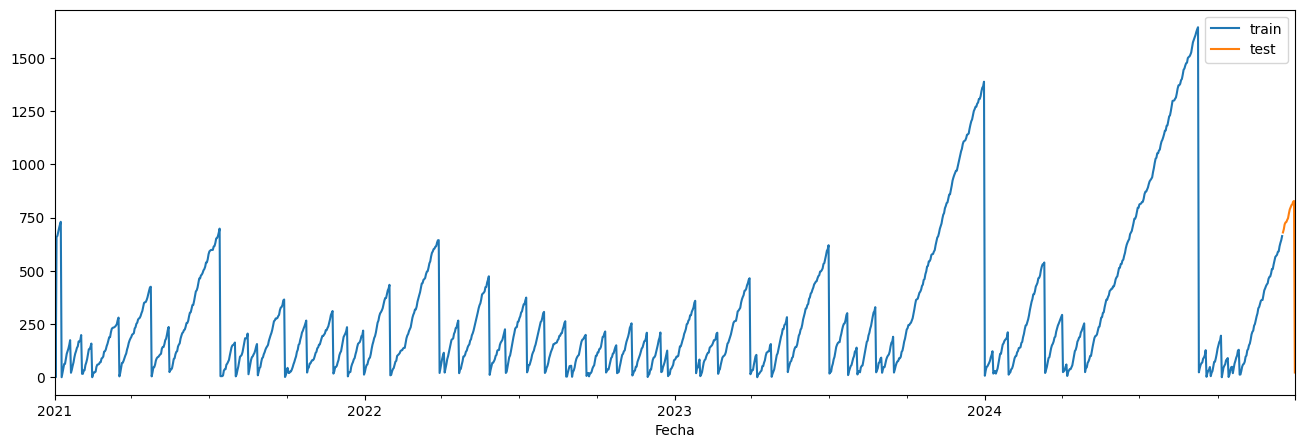

In [67]:
steps = 15
datos_train = equipo_fq[:-steps]
datos_test  = equipo_fq[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();

In [68]:
datos_train.columns

Index(['Temperatura_C', 'Vibracion_mm_s', 'Horas_Operativas', 'Fallo'], dtype='object')

##  Forecasting autorregresivo recursivo

In [69]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=123),
    lags=480,
)

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470 471 472 473 474 475 476 477 478 479 480] 
Window features: None 
Window size: 480 
Exogenous included: True 
Exogenous names: Temperatura_C, Vibracion_mm_s, Fallo 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-24 15:59:52 
Last fit date: 2025-04-24 15:59:52 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [70]:
# Predicciones
exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
# predicciones.index = datos_test.index
predicciones

2024-12-17    635.102707
2024-12-18    623.938456
2024-12-19    658.001087
2024-12-20    671.893410
2024-12-21    704.892818
2024-12-22    683.492610
2024-12-23    689.321681
2024-12-24    693.354754
2024-12-25    522.971607
2024-12-26    559.993379
2024-12-27    522.950892
2024-12-28    533.123427
2024-12-29    585.782045
2024-12-30    579.241266
2024-12-31    346.186625
Freq: D, Name: pred, dtype: float64

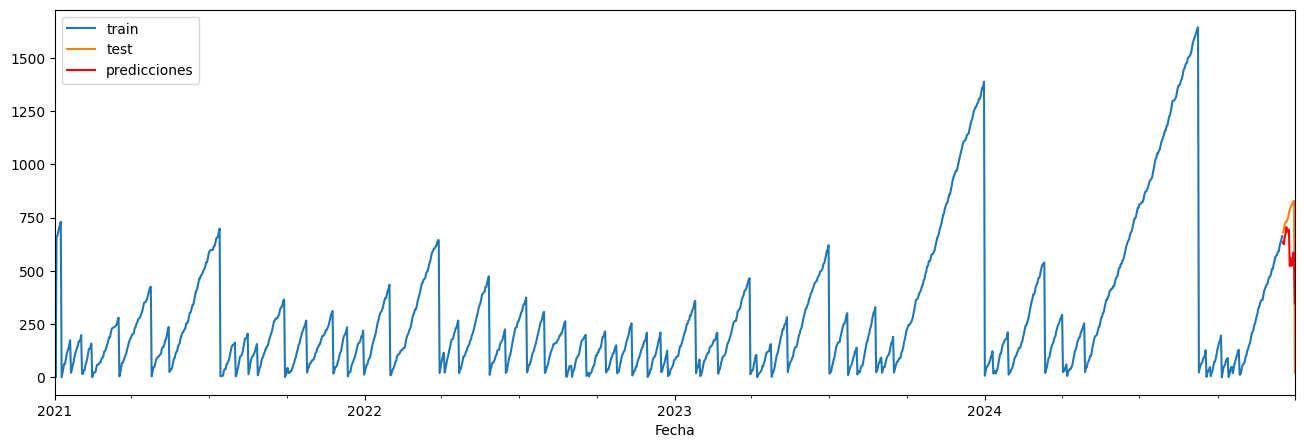

In [71]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="red")
ax.legend()

In [72]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100, 2)}%")

Error de test (mse): 35736.75608493851
Varianza datos: 101688.87860257094
mse2var: 35.14%


### Búsqueda de hiperparámetros: grid search

In [91]:
# Búsqueda de hiperparámetros: grid search

forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=123),
    lags=12,  # Este valor será remplazado en el grid search
)


# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=int(len(datos_train) * 0.5),
    refit=False,
    fixed_train_size=False,
)

# Valores candidatos de lags
lags_grid = [10, 50, 100, 150]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
    'alpha': [0.1, 1, 10, 100],
}

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=True,
    exog=exogs_train,
)

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 723
Number of observations used for backtesting: 723
    Number of folds: 49
    Number skipped folds: 0 
    Number of steps per fold: 15
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2022-12-24 00:00:00  (n=723)
    Validation: 2022-12-25 00:00:00 -- 2023-01-08 00:00:00  (n=15)
Fold: 1
    Training:   No training in this fold
    Validation: 2023-01-09 00:00:00 -- 2023-01-23 00:00:00  (n=15)
Fold: 2
    Training:   No training in this fold
    Validation: 2023-01-24 00:00:00 -- 2023-02-07 00:00:00  (n=15)
Fold: 3
    Training:   No training in this fold
    Validation: 2023-02-08 00:00:00 -- 2023-02-22 00:00:00  (n=15)
Fold: 4
    Training:   No training in this fold
    Validation: 2023-02-23 00:00:00 -- 2023-03-09 00:00:00  (n=15)
Fold: 5
    Training

In [74]:
# Resultados de la búsqueda de hiperparámetros

resultados_grid.sort_values(
    by=['mean_squared_error'],
    ascending=True,
    inplace=True
)

bestfc = resultados_grid.loc[0]
bestfc

lags                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
lags_label            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
params                                                   {'alpha': 0.1}
mean_squared_error                                         34939.111035
alpha                                                               0.1
Name: 0, dtype: object

In [75]:
best_lags = len(bestfc.lags)
best_params = bestfc.params

### Modelo final

In [76]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=Ridge(alpha=best_params['alpha'], random_state=123),
    lags=best_lags,
)

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Window features: None 
Window size: 50 
Exogenous included: True 
Exogenous names: Temperatura_C, Vibracion_mm_s, Fallo 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-24 15:59:54 
Last fit date: 2025-04-24 15:59:54 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [77]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.index = datos_test.index
predicciones

Fecha
2024-12-17    660.434163
2024-12-18    660.269658
2024-12-19    660.231441
2024-12-20    657.677967
2024-12-21    655.421099
2024-12-22    656.727173
2024-12-23    655.200074
2024-12-24    655.220823
2024-12-25    655.452340
2024-12-26    655.375959
2024-12-27    654.525616
2024-12-28    653.535295
2024-12-29    654.884582
2024-12-30    656.101323
2024-12-31    377.692175
Freq: D, Name: pred, dtype: float64

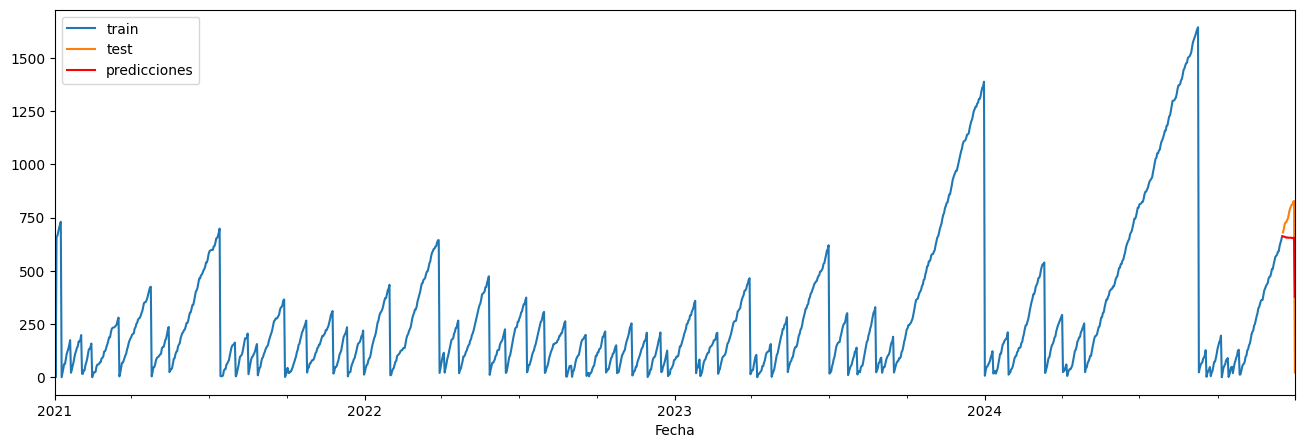

In [78]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="red")
ax.legend()

In [79]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100, 2)}%")

Error de test (mse): 20968.628062302832
Varianza datos: 101688.87860257094
mse2var: 20.62%


##  Forecasting Multi Step Direct

In [80]:
# Crear y entrenar forecaster

forecaster = ForecasterDirect(
    regressor=Ridge(random_state=123),
    transformer_y=StandardScaler(),
    steps=15,
    lags=30
)

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

================ 
ForecasterDirect 
================ 
Regressor: Ridge 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window features: None 
Window size: 30 
Maximum steps to predict: 15 
Exogenous included: True 
Exogenous names: Temperatura_C, Vibracion_mm_s, Fallo 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-24 15:59:55 
Last fit date: 2025-04-24 15:59:55 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [81]:
# Predicciones
exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.index = datos_test.index
predicciones

Fecha
2024-12-17    660.252711
2024-12-18    650.286947
2024-12-19    641.844121
2024-12-20    625.328083
2024-12-21    625.583089
2024-12-22    614.222978
2024-12-23    617.398471
2024-12-24    610.555368
2024-12-25    588.028569
2024-12-26    569.823195
2024-12-27    583.986818
2024-12-28    555.665966
2024-12-29    579.757162
2024-12-30    567.678572
2024-12-31    281.306810
Freq: D, Name: pred, dtype: float64

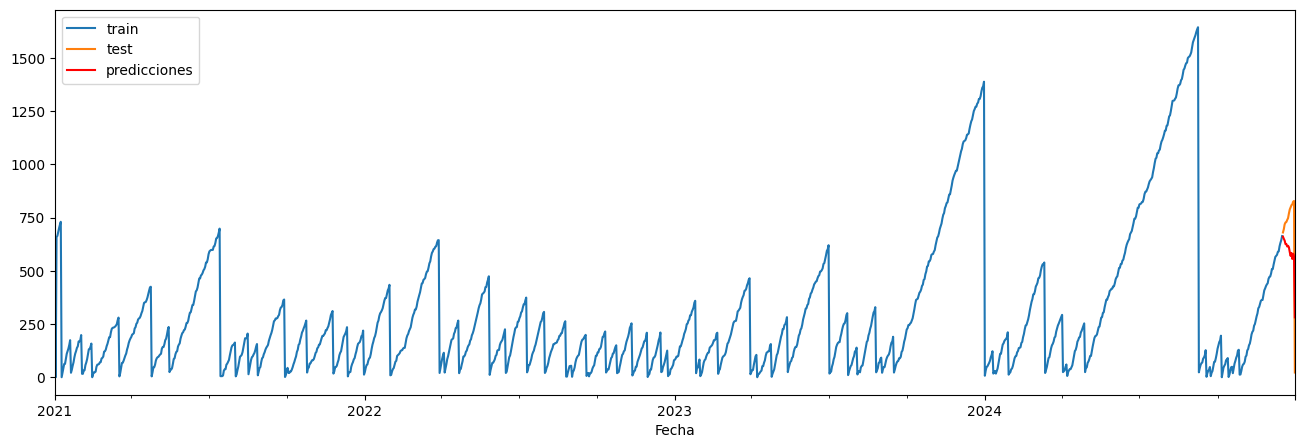

In [82]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="red")
ax.legend()

In [83]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100, 2)}%")

Error de test (mse): 32619.722114603886
Varianza datos: 101688.87860257094
mse2var: 32.08%


### Búsqueda de hiperparámetros: grid search

In [92]:
# Búsqueda de hiperparámetros: grid search

forecaster = ForecasterDirect(
    regressor=Ridge(random_state=123),
    transformer_y=StandardScaler(),
    steps=15,
    lags=30
)


# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=int(len(datos_train) * 0.5),
    refit=False,
    fixed_train_size=False,
)

# Valores candidatos de lags
lags_grid = [10, 50, 100, 150]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
    'alpha': [0.1, 1, 10, 100],
}

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=True,
    exog=exogs_train,
)

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 723
Number of observations used for backtesting: 723
    Number of folds: 49
    Number skipped folds: 0 
    Number of steps per fold: 15
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2022-12-24 00:00:00  (n=723)
    Validation: 2022-12-25 00:00:00 -- 2023-01-08 00:00:00  (n=15)
Fold: 1
    Training:   No training in this fold
    Validation: 2023-01-09 00:00:00 -- 2023-01-23 00:00:00  (n=15)
Fold: 2
    Training:   No training in this fold
    Validation: 2023-01-24 00:00:00 -- 2023-02-07 00:00:00  (n=15)
Fold: 3
    Training:   No training in this fold
    Validation: 2023-02-08 00:00:00 -- 2023-02-22 00:00:00  (n=15)
Fold: 4
    Training:   No training in this fold
    Validation: 2023-02-23 00:00:00 -- 2023-03-09 00:00:00  (n=15)
Fold: 5
    Training

In [85]:
# Resultados de la búsqueda de hiperparámetros

resultados_grid.sort_values(
    by=['mean_squared_error'],
    ascending=True,
    inplace=True
)

bestfc = resultados_grid.loc[0]
bestfc

lags                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lags_label            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
params                                 {'alpha': 0.1}
mean_squared_error                       75620.472914
alpha                                             0.1
Name: 0, dtype: object

In [86]:
best_lags = len(bestfc.lags)
best_params = bestfc.params

### Modelo final

In [93]:
# Crear y entrenar forecaster

forecaster = ForecasterDirect(
    regressor=Ridge(alpha=best_params['alpha'], random_state=123),
    transformer_y=StandardScaler(),
    steps=steps,
    lags=best_lags
)

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

================ 
ForecasterDirect 
================ 
Regressor: Ridge 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: None 
Window size: 10 
Maximum steps to predict: 15 
Exogenous included: True 
Exogenous names: Temperatura_C, Vibracion_mm_s, Fallo 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-24 16:06:39 
Last fit date: 2025-04-24 16:06:39 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [94]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
# predicciones.index = datos_test.index
predicciones

2024-12-17    661.652399
2024-12-18    649.725802
2024-12-19    640.046362
2024-12-20    623.585409
2024-12-21    625.049426
2024-12-22    609.668822
2024-12-23    613.634671
2024-12-24    606.277687
2024-12-25    581.079404
2024-12-26    561.126269
2024-12-27    577.072695
2024-12-28    548.144833
2024-12-29    567.438918
2024-12-30    556.266364
2024-12-31    264.502475
Freq: D, Name: pred, dtype: float64

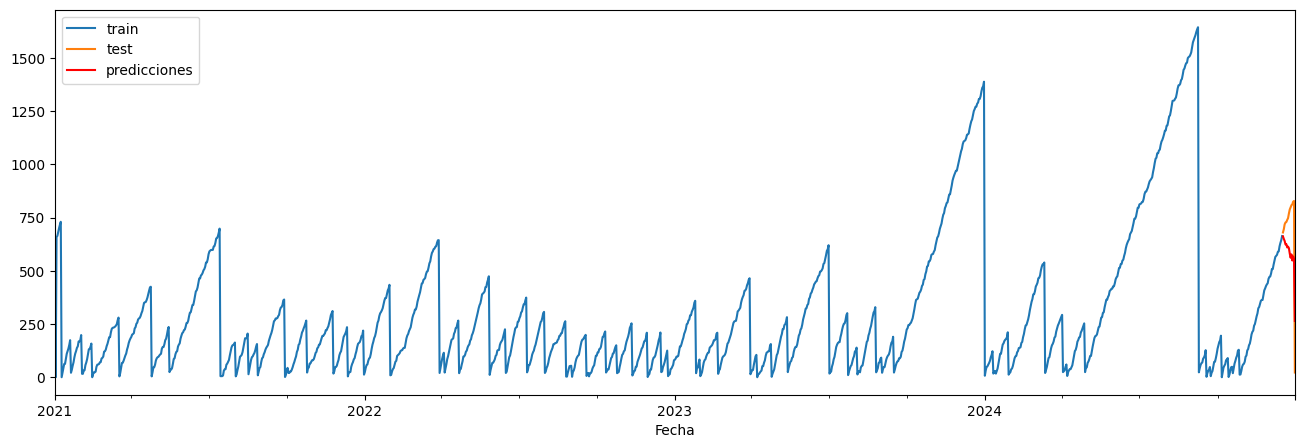

In [95]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="red")
ax.legend()

In [96]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100, 2)}%")

Error de test (mse): 34086.48980926492
Varianza datos: 101688.87860257094
mse2var: 33.52%
